
# Stacked Denoising autoencoder
Trying the reproduce the results from (http://jmlr.org/papers/volume11/vincent10a/vincent10a.pdf)
    
    Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion

The big issue for me is that I am not able to reproduce the filters the authors obtain: 
- They get blob/edge detectors
- I get some random crap

*Solution*
- needed a pretty large sample size
- 50000 samples didnt suffice
- 500000 samples gets us the desired filters

*Requirements*:
- lasagne
- nolearn

In [11]:
import numpy as np
import scipy.io
from lasagne.layers import get_output, InputLayer, DenseLayer, GaussianNoiseLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh, linear
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo
from nolearn.lasagne import visualize
from nolearn.lasagne import visualize
from nolearn.lasagne.visualize import plot_loss
import theano
from lasagne.init import GlorotUniform
from plottingUtils import tile_raster_images

%pylab

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [21]:
%matplotlib inline

## Load the data from Olshausen, create 12x12 patches
data used in section 5.1, "natural images"

In [4]:
#download the data
import urllib.request
import os
if not os.path.exists("Olshausen.mat"):
    urllib.request.urlretrieve ("http://redwood.berkeley.edu/bruno/sparsenet/IMAGES.mat", "Olshausen.mat")

In [5]:
theImages = scipy.io.loadmat('Olshausen.mat')['IMAGES']

def get_random_patch(images, patchsize=12):
    """extracts a single random patch from the 3d matrix of images with shape: (x, y, samples)"""
    q,_, N = images.shape
    r = np.random.randint(N)
    x, y =  np.random.randint(q-patchsize,  size=(2,)) # q-N to stay within the image

    return images[x:x+patchsize,y:y+patchsize, r]

patchSize= 12
sampleSize = 500000
X = np.stack([get_random_patch(theImages,patchSize) for i in range(sampleSize)], axis=0)
X_out = X.reshape((X.shape[0], -1)) # flatten to compare vs last layer

# Experiment 1: linear undercomplete coder/decoder, no noise added
section 5.1 in their paper

Here the issue might be that my training set is too small

In [24]:
"""first experiment: a linear encoder/decoder, squared loss"""
encode_size = 50

# to get tied weights in the encoder/decoder, create this shared weightMatrix
sharedWeights = theano.shared(GlorotUniform().sample(shape=(X.shape[1]**2, encode_size))) #

layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2])}),
    (DenseLayer, {'name': 'encoder', 'num_units': encode_size, 'nonlinearity': rectify, 'W': sharedWeights }),
    (DenseLayer, {'name': 'decoder','num_units': patchSize**2, 'nonlinearity': linear, 'W': sharedWeights.T}),
]

ae1 = NeuralNet(
    layers=layers,
    max_epochs=100,
    update=nesterov_momentum,
    update_learning_rate=0.05,
    update_momentum=0.975,
    regression=True,
    verbose=1
)

In [ ]:
ae1.fit(X, X_out);

    101       0.00892       0.00900      0.99124  7.92s
    102       0.00892       0.00900      0.99117  8.36s
    103       0.00891       0.00899      0.99110  9.61s
    104       0.00891       0.00899      0.99104  10.91s
    105       0.00890       0.00898      0.99099  8.46s
    106       0.00890       0.00898      0.99094  8.55s
    107       0.00889       0.00898      0.99090  10.03s
    108       0.00889       0.00897      0.99086  5.13s
    109       0.00889       0.00897      0.99083  6.12s
    110       0.00889       0.00897      0.99079  7.44s
    111       0.00888       0.00897      0.99076  7.06s
    112       0.00888       0.00896      0.99073  6.98s
    113       0.00888       0.00896      0.99070  10.65s
    114       0.00888       0.00896      0.99067  10.66s
    115       0.00888       0.00896      0.99064  8.70s
    116       0.00887       0.00896      0.99062  7.93s
    117       0.00887       0.00896      0.99059  10.47s
    118       0.00887       0.00896      0.

(0.008, 0.01)

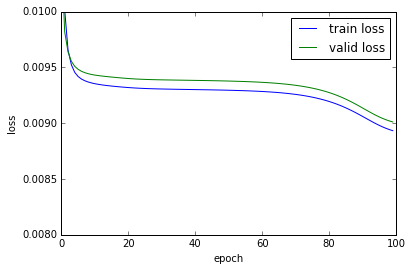

In [29]:
plot_loss(ae1)
plt.ylim([0.008, 0.010])

## inspect the reconstruction

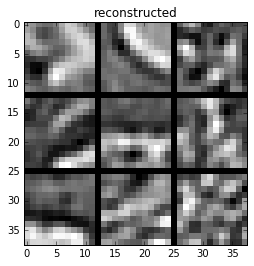

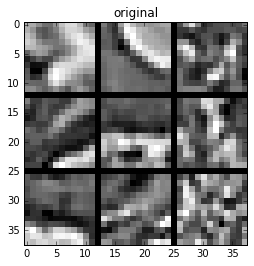

In [27]:
X_pred = ae1.predict(X)
tile_raster_images(X_pred[0:9,:], (patchSize,patchSize), (3,3), tile_spacing=(1,1))
title('reconstructed')
tile_raster_images(X_out[0:9,:], (patchSize,patchSize), (3,3), tile_spacing=(1,1));
title('original');

## inspect the learned filters

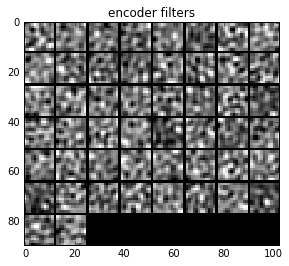

In [28]:
W_encode = ae1.layers_['encoder'].W.get_value()
tile_raster_images(W_encode.T, (patchSize,patchSize), (7,8), tile_spacing=(1,1)); title('encoder filters')

doesnt really look like the "blob detectors" in Figure 5 middle

# Experiment 2: overcomplete AE with Gaussian noise
using a GaussianNoise layer to corrupt the images each epoch

In [8]:
sigma = 0.5 #corrupt the data with gaussian noise
encode_size = 200

# again, tied weights in the en/decoder
sharedWeights2 = theano.shared(GlorotUniform().sample(shape=(X.shape[1]**2, encode_size))) #
layers2 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2])}),
    (GaussianNoiseLayer, {'name': 'corrupt', 'sigma': sigma}),
    (DenseLayer, {'name': 'encoder', 'num_units': encode_size, 'nonlinearity': rectify, 'W': sharedWeights2 }),
    (DenseLayer, {'name': 'decoder','num_units': patchSize**2, 'nonlinearity': linear, 'W': sharedWeights2.T}),
]

ae2 = NeuralNet(
    layers=layers2,
    max_epochs=100,
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    regression=True,
    verbose=1
)

In [18]:
ae2.fit(X, X_out);

     30       0.04074       0.03437      1.18543  35.02s
     31       0.04073       0.03433      1.18643  37.99s
     32       0.04068       0.03434      1.18465  34.40s
     33       0.04062       0.03423      1.18672  35.28s
     34       0.04060       0.03423      1.18615  36.10s
     35       0.04057       0.03419      1.18676  37.67s
     36       0.04053       0.03419      1.18540  36.93s


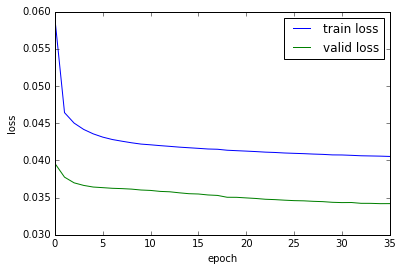

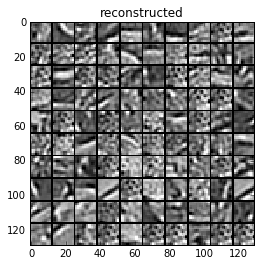

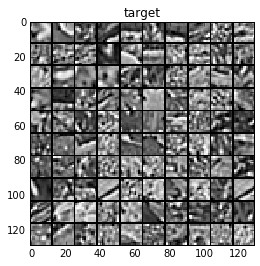

In [22]:
plot_loss(ae2)#;ylim([0.005,0.01])

# predictions
X_pred = ae2.predict(X)
tile_raster_images(X_pred[0:100,:], (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('reconstructed')
tile_raster_images(X_out[0:100,:], (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('target')

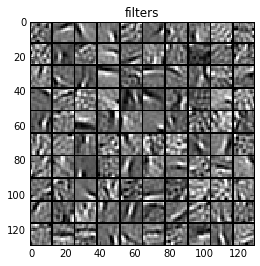

In [23]:
#filters
W_encode = ae2.layers_['encoder'].W.get_value()
tile_raster_images(W_encode.T, (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('filters');

already looks like the edge detectors in the paper. A couple more epochs should get thme even better